In [1]:
import sys
sys.executable

'/usr/bin/python3'

# Hand-written digit recognition (MNIST database)

### Based on the book by Michael Nielsen, @ http://neuralnetworksanddeeplearning.com/index.html 

### Code on GitHub @ https://github.com/mnielsen/neural-networks-and-deep-learning

<img src="mnist_100_digits.png" style="width: 500px;"/>

## 1) Introduction to the algorithm

#### MNIST dataset (how it is loaded)

<code>training_data</code>, <code>validation_data</code>, <code>test_data</code> are iterators containing pairs of input-output arrays:
* <code>training_data</code> contains 50000 pairs, and is used to train the network
* <code>test_data</code> contains 10000 pairs, and is used to test the performance of the network;
* <code>validation_data</code> also contains 10000 pairs and is used as extra ''testing'' data (to set hyper-parameters)

#### Setup the network and calculate the optimum parameters via Stochastic Gradient Descent of the mean-square error cost function

* Define a network with given numbers of nodes per layer (784 is the number of pixels of input images, 10 is the output vector)
<br/><br/>

* Define the parameters of the learning:
    * <code>epochs</code> is the number of complete *sweeps* over the training data
    <br/><br/>
    
    * <code>mini_batch_size</code> is the number of data points used for the evaluation of the gradient (i.e. between two steepest descent steps), $S$
    <br/><br/>
    
    * <code>eta</code> is the learning rate, $\eta$
    <br/><br/>
    
    * $\ldots$

* Define a cost function (defined inside the <code>Network</code> class), i.e. the mean-square error function
    
    $$
        C = \frac{1}{N}\sum_x \underbrace{\big\| a^L(x) - y(x) \big\|^2}_{C_x}
    $$
    
* **Train the network**.  For every epoch, 

    1. shuffle the training data (or the portion of training data passed to the SGD function) and divide them into mini-batches of size $S$;
    <br/><br/>
    
    2. for each mini-batch calculate the gradient of the cost with respect to the parameters, as $ \nabla_{w,b} C \simeq \overline{\nabla_{w,b} C} $ (where $\,\overline{\,\bullet\,}\,$ indicates the sample mean over the mini-batch) using the **backpropagation** algorithm (see below) and take a gradient descent step as $$
            w \leftarrow w - \eta\,\overline{\frac{\partial C}{\partial w}}
            \qquad \textrm{and} \qquad
            b \leftarrow b - \eta\,\overline{\frac{\partial C}{\partial b}}$$
    <br/><br/>

    4. Test the performance with the <code>test_data</code>

### How backpropagation works

For a given input $x$:

1. **Set the input** as $a^1_j(x) = x_j$
<br/><br/>

2. **Feedforward**: For all the subsequent layers, compute $a_j^L(x)$, by iterating $ a_i^l = \sigma(z_i^l)$ where

    $$ z_i^l = \sum_j w^{l-1}_{ij} a_j^{l-1} $$
    for all $l = 2,\ldots L$
<br/><br/>
    
3. Calculate the output **error**:

    $$ \delta_j^L(x) = \sigma'\big(z^L_j\big)\frac{\partial C_x}{\partial a^L_j} $$
    <br/>

4. **Propagate** the error **backward**: for all the previous layers, $l = L-1, \ldots 2$, iterate

    $$ \delta^l_i = \sigma'\big(z^l_i\big)\,\sum_j w_{ji}^{l+1} \delta_j^{l+1} $$
    <br/>
    
5. **Derivatives of the cost** with respect to weights and biases are

    $$
        \frac{\partial C_x}{\partial w^{l}_{ij}} = a_j^{l-1} \delta^l_i
        \qquad \textrm{ and } \qquad
        \frac{\partial C_x}{\partial b_i} = \delta^l_i
    $$
    
    
These derivatives are accumulated into the sample mean over the mini-batch data,

$$
    \overline{\frac{\partial C}{\partial w^{l}_{ij}}} \simeq \frac{1}{S}\sum_x \frac{\partial C_x}{\partial w^{l}_{ij}}
        \qquad \textrm{ and } \qquad
        \overline{\frac{\partial C}{\partial b^{l}_{j}}} \simeq \frac{1}{S}\sum_x \frac{\partial C_x}{\partial b^{l}_{i}}
$$

## 2) A look at the code

#### Load the needed libraries

In [1]:
import pickle
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt

####  Loading the MNIST database

In [3]:
def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    
    The ``training_data`` is returned as a tuple with two entries.
    - The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    - The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """
    In order to train the neural network it is convenient to arrange
    the training data differently.    
    
    Return a tuple containing ``(training_data, validation_data,
    test_data)``. 
    
    ``training_data`` is a list containing 50,000 2-tuples ``(x, y)``.
    ``x`` is a 784-dimensional numpy.ndarray containing the input image.
    ``y`` is a 10-dimensional numpy.ndarray representing the unit vector
    corresponding to the correct digit for ``x``.
       
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the corresponding
    classification, i.e., the digit values (integers) corresponding to ``x``.
    
    NOTE: the 3-tuple returned contains 'zip' objects, which are iterators.
    They are meant to be used only once in, e.g. 'for' cycles. Once used, the
    function 'load_data_wrapper' must be called again if we need the databases
    for another training. Otherwise, cast the zip object into a list, e.g.
    'training_data = list(training_data)'
    """
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    
    # see 'vectorized_result' function below
    training_results = [vectorized_result(y) for y in tr_d[1]]
    
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

#### Definition of the `Network` class (`Network` object and functions operating on it)

In [4]:
class Network(object):

    def __init__(self, sizes):
        """
        This states how the object ``Network`` is defined.
        
        The initializer takes as argument a list (``sizes``) containing
        the number of neurons in the respective layers of the network.
        
        For example, if the list was [2, 3, 1] then it would be a
        three-layer network, with the first layer containing 2 neurons,
        the second layer 3 neurons, and the third layer 1 neuron.
        
        The biases and weights for the network are initialized randomly,
        using a Gaussian distribution with mean 0, and variance 1.
        
        NOTE: the first layer is assumed to be an input layer,
        and by convention we won't set any biases for those neurons,
        since biases are only ever used in computing the outputs from
        later layers.
        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data):
        """
        Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially.
        """

        # data to be used to train the network
        training_data = list(training_data)
        n = len(training_data)
        
        # data to check performance at the end of each epoch
        test_data = list(test_data)
        n_test = len(test_data)
        
        
        evaluation_accuracy = []
        training_accuracy = []
        for j in range(epochs):
            # shuffle to avoid effects of undesired correlations
            random.shuffle(training_data)
            
            # split data into ``mini_batches``
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            # each of them is used to estimate the gradient of the 
            # cost function in order to perform stochastic gradient
            # descent (SGD)
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            correct = self.accuracy(test_data)
            print("Epoch {} : {} / {}".format(j,correct,n_test));
            evaluation_accuracy.append(correct/n_test)
            
            correct = self.accuracy(training_data, convert=True)
            training_accuracy.append(correct/n)
            
        return training_accuracy, evaluation_accuracy
    
    

    def update_mini_batch(self, mini_batch, eta):
        """
        Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate.
        """
        
        # define the gradient vectors (with respect to the biases and
        # the weights)
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # use the minibatch (passed as argument) to evaluate the 
        # gradients through backpropagation (see function `backprop`
        # below)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # change the weights of the `Network` object
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """
        This function is the core of the learning algorithm: backpropagation
        
        Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.
        ``nabla_b`` and ``nabla_w`` are layer-by-layer lists of
        numpy arrays, similar to ``self.biases`` and ``self.weights``.
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        #
        # 1. feedforward: calculate inputs and activities at each layer
        #
        activation = x    # this is the input layer (passed as argument)
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        #
        # 2. backward pass: calculate the ``error`` at each layer
        #      by propagating errors back
        #
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the numeration of layers, here grows from the output
        # to the input layer (Python convention for negative indices in
        # lists)
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)


    def cost_derivative(self, output_activations, y):
        """
        Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations.
        """
        return (output_activations-y)


    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy
    

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

## 3) Let's get to the training

In [6]:
#import mnist_loader
training_data, validation_data, test_data = load_data_wrapper()

#import network
net = Network([784, 30, 10])

epochs = 30
mini_batch_size = 10
eta = 3.0

### uncomment to reduce the training data set
n_training = 1000  # < 50000
training_data = list(training_data)[:n_training]

n_test = 1000
test_data = list(test_data)[:n_test]

training_accuracy, evaluation_accuracy = net.SGD(training_data, epochs, mini_batch_size, eta, test_data)

Epoch 0 : 352 / 1000
Epoch 1 : 424 / 1000
Epoch 2 : 530 / 1000
Epoch 3 : 604 / 1000
Epoch 4 : 647 / 1000
Epoch 5 : 677 / 1000
Epoch 6 : 690 / 1000
Epoch 7 : 708 / 1000
Epoch 8 : 719 / 1000
Epoch 9 : 731 / 1000
Epoch 10 : 739 / 1000
Epoch 11 : 735 / 1000
Epoch 12 : 746 / 1000
Epoch 13 : 752 / 1000
Epoch 14 : 755 / 1000
Epoch 15 : 756 / 1000
Epoch 16 : 762 / 1000
Epoch 17 : 754 / 1000
Epoch 18 : 768 / 1000
Epoch 19 : 774 / 1000
Epoch 20 : 773 / 1000
Epoch 21 : 772 / 1000
Epoch 22 : 774 / 1000
Epoch 23 : 774 / 1000
Epoch 24 : 777 / 1000
Epoch 25 : 777 / 1000
Epoch 26 : 782 / 1000
Epoch 27 : 781 / 1000
Epoch 28 : 779 / 1000
Epoch 29 : 778 / 1000


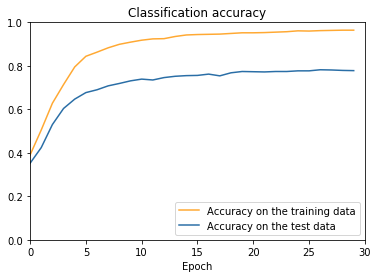

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 30, 1), training_accuracy, color='#FFA933',
            label="Accuracy on the training data")
ax.plot(np.arange(0, 30, 1), evaluation_accuracy, color='#2A6EA6', 
            label="Accuracy on the test data")
ax.set_xlim(0, epochs)
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.set_title('Classification accuracy')
plt.legend(loc="lower right")
plt.show()

## Exercise

#### 1. Explore the parameters of the network
**?)** What is the performance when the number of layers is increased?

#### 2.  Change the structure of the output
The code as it is constructs a neural network in which the last layer has 10 nodes, and the "answer" of the network for the classification of the input image is the index of the node which has maximum activity. 

**?)** How does the code change if we want as "answer" the binary representation of the number?

**?)** How is the performance affected?

*Practical hint:* one need to change the functions ``vectorized_result`` and ``accuracy``